# Data wrangling 

In [1]:
import preprocessing as pre
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import permutation_test_score
import matplotlib.pyplot as plt
from sklearn import metrics
import plotly.express as px
from sklearn import preprocessing

### Data for behavioral and self-report assessment

First let's import the neuro dataset (neuropsychological assessment)

In [2]:
neuro = pd.read_excel("Data/Neuropsy.xlsx", na_values='.').dropna()
neuro['ID']='id_'+neuro['ID'].astype(str)
neuro.rename(columns={'ID':'id'}, inplace=True)# rename ID to id (to match eeg dataset)
neuro['subtype'] = neuro.apply(lambda x: pre.categorize_subtypes(x['inat'], x['hyper']), axis=1)# create a column with categorized subtybes (based on clinical thresholds)
neuro['is_inat'] = neuro['subtype'].apply(lambda x: 0 if x=='hyper' else 1) # create a columns to label prensence of inat and hyper
neuro['is_hyper'] = neuro['subtype'].apply(lambda x: 0 if x=='inat' else 1)
neuro.reset_index(drop=True, inplace = True) # reset index as lines were removed with na_drop
neuro

,id,Age,Gender,cIM,cHR,cIE,cSC,inat,hyper,Aqtot,Aqaudi,Aqvis,RCQtot,RCQaudi,RCQvis,subtype,is_inat,is_hyper
0,id_1,21,1,17.0,31.0,29.0,9.0,18.0,20.0,90.0,91.0,92.0,94.0,80.0,110.0,mixed,1,1
1,id_3,20,1,10.0,5.0,13.0,1.0,8.0,5.0,27.0,34.0,41.0,25.0,31.0,38.0,mixed,1,1
2,id_4,18,1,26.0,17.0,7.0,15.0,23.0,11.0,93.0,89.0,96.0,90.0,92.0,90.0,inat,1,0
3,id_7,23,1,24.0,8.0,6.0,14.0,19.0,3.0,86.0,66.0,112.0,94.0,90.0,100.0,inat,1,0
4,id_11,21,1,16.0,26.0,13.0,10.0,17.0,13.0,45.0,33.0,78.0,69.0,51.0,94.0,mixed,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,id_602,19,1,25.0,14.0,20.0,18.0,21.0,8.0,80.0,87.0,77.0,71.0,71.0,79.0,inat,1,0
92,id_603,19,1,32.0,15.0,14.0,15.0,22.0,9.0,111.0,103.0,118.0,63.0,78.0,56.0,inat,1,0
93,id_700,18,2,13.0,33.0,14.0,11.0,18.0,15.0,83.0,80.0,89.0,70.0,72.0,75.0,mixed,1,1
94,id_701,19,1,22.0,17.0,15.0,12.0,15.0,11.0,0.0,20.0,0.0,29.0,32.0,42.0,mixed,1,1


In [3]:
neuro.Gender.value_counts() #verify sample gender 

1    57
2    39
Name: Gender, dtype: int64

Import all all excel files into one df following function from our .py file

In [53]:
eeg = pre.process_all_excel_files()
eeg['fft_abs_power'] = eeg['fft_abs_power'].astype(float)
eeg['id'] = eeg['id'].astype(int)
eeg['id'] ='id_'+eeg['id'].astype(str)
eeg = eeg[['id', 'brain_oscillation','electrode', 'fft_abs_power']]
print(eeg.shape)
eeg.head(5)

(21109, 4)


,id,brain_oscillation,electrode,fft_abs_power
0,id_134,Delta,FP1,15.565495
1,id_134,Delta,FP2,13.945462
2,id_134,Delta,F7,10.874886
3,id_134,Delta,F3,13.581803
4,id_134,Delta,Fz,15.644595


Selecting brain_oscillations of interest only

In [ ]:
eeg = eeg.loc[(eeg['brain_oscillation'] != 'HighBeta') & (eeg['brain_oscillation'] != 'HighGamma') & (eeg['brain_oscillation'] != 'Gamma')]
eeg.brain_oscillation.value_counts()
eeg

#### Pool of electrodes for analyses purposes

In [ ]:
eeg['electrode_pool'] = eeg['electrode'].apply(lambda x: pre.electrode_pools(x))
eeg = eeg[['id', 'brain_oscillation','electrode_pool', 'electrode', 'fft_abs_power']]
eeg

## Setting up df for analysis

Drop hyper subtype as under represented n=2 on a n=96 sample

In [ ]:
neuro.drop(neuro[ neuro['subtype'] == 'hyper' ].index , inplace=True)
neuro.subtype.value_counts()

Merge dataframes togeter and keep columns of interest

In [ ]:
#inner join to keep ids present in both dataframes
df = pd.merge(eeg, neuro[['id', 'Gender','subtype','is_inat','is_hyper', 'inat','hyper']], on='id', how='inner')
# Sort the rows of dataframe by column 'id'
df = df.sort_values(by ='id' )
df_gender = df
print(df.shape)
print(len(df.id.unique()))
df.head()

Create here the label df because otherwise it gets tricky

## Target df creation 

In [ ]:
labels = neuro[['id','subtype']].copy()
labels.set_index('id', inplace=True)
le = preprocessing.LabelEncoder()
labels['subtype'] = le.fit_transform(labels['subtype'])
labels

In [ ]:
hyper_labels = df['is_hyper']
inat_labels = df['is_inat']
gender_labels = df['Gender']

# Descriptive stats

## Descriptive stats table of spectral power by brain oscillation and subtypes

In [ ]:
df_desc = df[['subtype','brain_oscillation','electrode_pool','electrode', 'fft_abs_power']]
df_desc.groupby(['brain_oscillation', 'subtype', 'electrode_pool']).describe()

## Some data vizualisation 

### Spectral power within each frequency band, for each electrode for each subtype

In [ ]:
graph_data = df.groupby(['electrode','brain_oscillation', 'subtype']).agg({'fft_abs_power':'mean'}).reset_index()
graph_data.sort_values(['brain_oscillation','fft_abs_power'] ,inplace=True)
fig = px.bar(graph_data, x='electrode', y='fft_abs_power', facet_col='brain_oscillation', color='subtype')
fig.show()

### Spectral power within each frequency band, for each electrode_pool by subtype

In [5]:
graph_data = df.groupby(['electrode_pool','brain_oscillation', 'subtype']).agg({'fft_abs_power':'mean'}).reset_index()
graph_data.sort_values(['brain_oscillation','fft_abs_power'] ,inplace=True)
fig = px.bar(graph_data, x='brain_oscillation', y='fft_abs_power', facet_col='electrode_pool', color='subtype')
fig.show()

NameError: name 'df' is not defined

# PCA and knn by electrode pools using brain oscillation as features

## PCA on electrode pools 

#### Retain one pool at a time

#### PCA targetting prediction of gender by features of electrode, brain oscillation, and scores at inat and hyper

In [6]:
df_agg = df.groupby(['id',"brain_oscillation", 'electrode_pool', 'subtype']).agg({'fft_abs_power': 'mean'}).reset_index()
df_agg.head()

NameError: name 'df' is not defined

Extract one electrode at a time to run PCA

### PCA on central

In [7]:
principalDf, fig, pca_exp_var = pre.pca_package(df_agg,'central',labels)
fig.show()
print("explained variance:",pca_exp_var)

NameError: name 'df_agg' is not defined

### KNN with these PCAs

In [8]:
accuracy, score, pvalue, confusion_matrix = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
print("Confusion matrices:", confusion_matrix)

NameError: name 'principalDf' is not defined

### Confusion matrix plot

In [9]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(knn, X_test, y_test,
                                 display_labels=['1','2'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

NameError: name 'knn' is not defined

### PCA on temporal

In [ ]:
principalDf, fig, pca_exp_var = pre.pca_package(df_agg,'temporal',labels)
fig.show()
print("explained variance:",pca_exp_var)

### KNN with these PCAs

In [10]:
accuracy, score, pvalue = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

NameError: name 'principalDf' is not defined

### PCA on occipital

In [11]:
principalDf, fig, pca_exp_var = pre.pca_package(df_agg,'occipital',labels)
fig.show()
print("explained variance:",pca_exp_var)

NameError: name 'df_agg' is not defined

### KNN with these PCAs

In [ ]:
accuracy, score, pvalue = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

### PCA on frontal

In [12]:
principalDf, fig, pca_exp_var = pre.pca_package(df_agg,'frontal',labels)
fig.show()
print("explained variance:",pca_exp_var)

NameError: name 'df_agg' is not defined

### KNN with these PCAs

In [13]:
accuracy, score, pvalue = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

NameError: name 'principalDf' is not defined

### PCA on parietal

In [ ]:
principalDf, fig, pca_exp_var = pre.pca_package(df_agg,'parietal',labels)
fig.show()
print("explained variance:",pca_exp_var)

### KNN with these PCAs

In [14]:
accuracy, score, pvalue = pre.knn_testing(principalDf, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

NameError: name 'principalDf' is not defined

# Comparisons KNN without PCA

## Central

In [15]:
eeg_transp = pca_features_df(df, 'central')

NameError: name 'pca_features_df' is not defined

### Knn on pools without Pcas

In [16]:
accuracy, score, pvalue = pre.def knn_testing_nopca(eeg_transp, labels):
(eeg_transp, labels)
print('Accuracy:',accuracy)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

SyntaxError: invalid syntax (<ipython-input-16-0bed81af0a55>, line 1)

## Temporal

In [17]:
bands_list = df['brain_oscillation'].unique()
print(bands_list)
eeg_trimmed = df.loc[df['electrode_pool'] == 'temporal']
eeg_transp = pd.DataFrame()
for band in bands_list:
    eeg_transp[band] = np.array(eeg_trimmed[eeg_trimmed['brain_oscillation'] == band]['fft_abs_power'])
eeg_transp.head(10)

NameError: name 'df' is not defined

In [ ]:
features = eeg_transp

In [ ]:
#create train, test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=2)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(
    knn, X_train, y_train, scoring="accuracy",  n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

## Frontal

In [18]:
bands_list = df['brain_oscillation'].unique()
print(bands_list)
eeg_trimmed = df.loc[df['electrode_pool'] == 'frontal']
eeg_transp = pd.DataFrame()
for band in bands_list:
    eeg_transp[band] = np.array(eeg_trimmed[eeg_trimmed['brain_oscillation'] == band]['fft_abs_power'])
eeg_transp.head(10)

NameError: name 'df' is not defined

In [ ]:
features = eeg_transp

In [ ]:
#create train, test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=2)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(
    knn, X_train, y_train, scoring="accuracy",  n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

## Parietal

In [19]:
bands_list = df['brain_oscillation'].unique()
print(bands_list)
eeg_trimmed = df.loc[df['electrode_pool'] == 'parietal']
eeg_transp = pd.DataFrame()
for band in bands_list:
    eeg_transp[band] = np.array(eeg_trimmed[eeg_trimmed['brain_oscillation'] == band]['fft_abs_power'])
eeg_transp.head(10)

NameError: name 'df' is not defined

In [ ]:
features = eeg_transp

In [ ]:
#create train, test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=2)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(
    knn, X_train, y_train, scoring="accuracy",  n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

## Occipital

In [20]:
bands_list = df['brain_oscillation'].unique()
print(bands_list)
eeg_trimmed = df.loc[df['electrode_pool'] == 'occipital']
eeg_transp = pd.DataFrame()
for band in bands_list:
    eeg_transp[band] = np.array(eeg_trimmed[eeg_trimmed['brain_oscillation'] == band]['fft_abs_power'])
eeg_transp.head(10)

NameError: name 'df' is not defined

In [ ]:
features = eeg_transp

In [ ]:
#create train, test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=2)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(
    knn, X_train, y_train, scoring="accuracy",  n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

# PCA on conners data

In [21]:
le = preprocessing.LabelEncoder()
#encode features with scitkit learn encoder
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
conners_knn = neuro
features = neuro
# encoding series with categorical variables
conners_knn['subtype'] = le.fit_transform(conners_knn['subtype'])
conners_knn = conners_knn[["cIM", 'cHR', 'cIE', "cSC", 'subtype']].copy()
# features
features = features[["cIM", 'cHR', 'cIE', "cSC"]].copy()

#### Standardize the data

In [22]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(features)

#### PCA Projection to 2D

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(features)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,13.943110,-9.314403
1,-15.670334,1.938755
2,-1.946086,2.056016
3,-8.797124,7.829237
4,0.793202,-9.592457
...,...,...
91,4.601929,8.242882
92,4.390471,8.179627
93,3.982507,-16.018474
94,0.469549,1.442076


#### Explained variance

In [24]:
pca.explained_variance_ratio_

array([0.49, 0.29])

In [25]:
labels = conners_knn['subtype']
labels.shape

(96,)

### KNN with these PCAs

#### Set features from PCAs

In [26]:
features = principalDf[['principal component 1','principal component 2']].copy()

In [27]:
#create train, test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=2)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [28]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.65


In [29]:
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(
    knn, X_train, y_train, scoring="accuracy",  n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

Classification score 0.6858333333333334 (pvalue : 0.009900990099009901)


/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


# PCA on behavioral data

In [30]:
le = preprocessing.LabelEncoder()
# encoding series with categorical variables
neuro_knn = neuro
features = neuro
neuro_knn['subtype'] = le.fit_transform(neuro_knn['subtype'])
neuro_knn = neuro_knn[['Aqtot','Aqaudi','Aqvis','RCQtot','RCQaudi','RCQvis', 'subtype']]
# features
features = features[['Aqtot','Aqaudi','Aqvis','RCQtot','RCQaudi','RCQvis']].copy()

In [31]:
label = neuro_knn['subtype']

#### Standardize the data

In [32]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(features)

#### PCA Projection to 2D

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(features)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,-33.310242,-22.153169
1,112.215690,0.714030
2,-32.095771,-11.066987
3,-31.539015,-23.366636
4,43.027232,-36.758661
...,...,...
91,2.889079,-2.428852
92,-28.488160,43.751407
93,-0.012743,2.670378
94,145.833008,-33.318743


#### Explained variance

In [34]:
pca.explained_variance_ratio_

array([0.63, 0.25])

In [35]:
labels = conners_knn['subtype']
labels.shape

(96,)

### KNN with these PCAs

#### Set features from PCAs

In [36]:
features = principalDf[['principal component 1','principal component 2']].copy()

In [37]:
#create train, test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=2)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [38]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6


In [39]:
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(
    knn, X_train, y_train, scoring="accuracy",  n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

Classification score 0.35583333333333333 (pvalue : 0.9405940594059405)


/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


# KNN with Conners data without PCA

In [40]:
le = preprocessing.LabelEncoder()
#encode features with scitkit learn encoder
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
conners_knn = neuro
features = neuro
# encoding series with categorical variables
conners_knn['subtype'] = le.fit_transform(conners_knn['subtype'])
conners_knn = conners_knn[["cIM", 'cHR', 'cIE', "cSC", 'subtype']].copy()
# features
features = features[["cIM", 'cHR', 'cIE', "cSC"]].copy()

In [41]:
label = conners_knn['subtype']

In [42]:
#create train, test sets
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=2)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [43]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7


In [44]:
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(
    knn, X_train, y_train, scoring="accuracy",  n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

Classification score 0.6308333333333332 (pvalue : 0.009900990099009901)


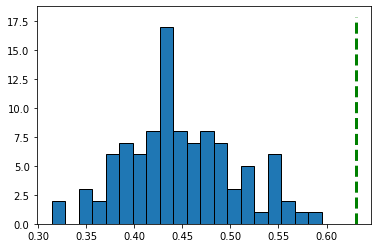

In [45]:
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)

# KNN on behavioral data without PCA

In [46]:
le = preprocessing.LabelEncoder()
# encoding series with categorical variables
neuro_knn = neuro
features = neuro
neuro_knn['subtype'] = le.fit_transform(neuro_knn['subtype'])
neuro_knn = neuro_knn[['Aqtot','Aqaudi','Aqvis','RCQtot','RCQaudi','RCQvis', 'subtype']]
# features
features = features[['Aqtot','Aqaudi','Aqvis','RCQtot','RCQaudi','RCQvis']].copy()

In [47]:
label = neuro_knn['subtype']

In [48]:
#create train, test sets
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=2)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [49]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6


In [50]:
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(
    knn, X_train, y_train, scoring="accuracy",  n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.

Classification score 0.39583333333333337 (pvalue : 0.7524752475247525)


/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/bea/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


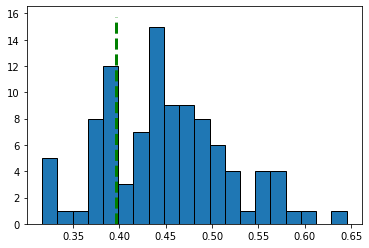

In [51]:
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)

# EEG KNN trying to predict  sex

In [52]:
le = preprocessing.LabelEncoder()
#encode features with scitkit learn encoder
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
features = df_gender
features = features[['electrode', 'brain_oscillation', 'fft_abs_power', 'inat', 'hyper']].copy()
# encoding series with categorical variables
features['electrode'] = le.fit_transform(features['electrode'])
features['brain_oscillation'] = le.fit_transform(features['brain_oscillation'])

NameError: name 'df_gender' is not defined

In [ ]:
eeg_dataset= pd.concat([features,gender_labels], axis=1).rename(columns={0: "labels"})
eeg_dataset

In [ ]:
#create train, test sets
X_train, X_test, y_train, y_test = train_test_split(features, gender_labels, test_size=0.2, random_state=4)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

### Permutation 

In [ ]:
import numpy as np
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(
    knn, X_train, y_train, scoring="accuracy",  n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

In [ ]:
import matplotlib.pyplot as plt
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)



#### Confusion matrix

In [ ]:
metrics.confusion_matrix(y_test, y_pred, normalize='true')
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html?highlight=confusion%20matrix

In [ ]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(knn, X_test, y_test,
                                 display_labels=['1','2'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()